In [2]:
from script import df_mobpro_brut, arr_marseille, arr_paris, arr_lyon, contours_comm, transport_dict, contours_comm, flux, plot_flux_gradient, plot_flux_gradient_zoom, coord_villes
from script import df_dossier_complet_brut
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.colors as colors
import networkx as nx
from scipy.sparse import coo_matrix

/home/onyxia/work/statapp/script.py:19: DtypeWarning: Columns (1,1687,1688) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:24: DtypeWarning: Columns (4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta_dossier_complet_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:34: DtypeWarning: Columns (1,2,3,4,14,15,16,18,22,24,27,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mobpro_brut = pd.read_csv(file)
/home/onyxia/work/statapp/script.py:102: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  contours_comm["centroid"] = contours_comm.geometry.centroid
/home/onyxia/work/statapp/script.py:111: UserWarning: Geometry is in a geographic CRS. Results from 'centroid'

antully: (46.89232199838103, 4.402852764409862)
le tremblay-omonville: (49.12081156432765, 0.9143802127565656)
vaux-lès-mouzon: (49.60389494206806, 5.136483053287144)
anchenoncourt-et-chazel: (47.8616809003776, 6.11534440434135)
culoz-béon: (45.85633732729717, 5.772905566192263)
domèvre-sur-avière: (48.22223470040439, 6.388423941842605)
bernoy-le-château: (49.32120314158208, 3.3070156677330558)
videcosville: (49.566672646936, -1.3714795795608266)
saint-agrève: (45.00542393638767, 4.413096930429594)
le bourg-d'oisans: (45.0340588974907, 6.032836629436181)


In [3]:
df_mobpro_brut.head(3)

,Unnamed: 0,COMMUNE,ARM,DCFLT,DCLT,AGEREVQ,CS1,DEROU,DIPL,EMPL,...,SEXE,STAT,STOCD,TP,TRANS,TYPL,TYPMR,VOIT,TRANS_LABEL,CS_LABEL
0,0,01001,ZZZZZ,99999,01001,40,2,Z,16,21,...,2,21,21,1,1,1,41,2,Pas de transport,"Artisans, commerçants, chef de société"
1,1,01001,ZZZZZ,99999,01001,45,5,Z,14,16,...,2,10,22,2,5,2,12,1,"Voiture, camion, fourgonnette",Employés
2,2,01001,ZZZZZ,99999,01001,20,2,Z,14,21,...,2,21,10,1,1,1,41,3,Pas de transport,"Artisans, commerçants, chef de société"


Ce que signifient chacune des en-têtes de colonnes :  
COMMUNE Département et commune du lieu de résidence  
ARM Arrondissement municipal de résidence (Paris, Lyon et Marseille)  
DCFLT Commune frontalière du lieu de travail  
DCLT Département, commune et arrondissement municipal (Paris, Lyon, Marseille) du lieu de travail  
AGEREVQ Âge quinquennal en années révolues  
CS1 Catégorie socioprofessionnelle en 8 postes  
DEROU Nombre de deux-roues à moteur du ménage (DOM)  
DIPL_15 Diplôme le plus élevé  
EMPL Condition d'emploi  
ILTUU Indicateur urbain du lieu de travail  
ILT Indicateur du lieu de travail  
IMMI Situation quant à l'immigration  
INATC Indicateur de nationalité condensé (Français/Étranger)  
INEEM Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage  
INPOM Nombre de personnes actives ayant un emploi du ménage  
INPSM Nombre de personnes scolarisées du ménage  
IPONDI Poids de l'individu  
LPRM Lien à la personne de référence du ménage  
METRODOM Indicateur Métropole ou DOM du lieu de résidence  
MOCO Mode de cohabitation  
NA5 Activité économique regroupée en 5 postes  
NPERR Nombre de personnes du ménage (regroupé)  
REGION Région du lieu de résidence  
REGLT Région du lieu de travail  
SEXE Sexe  
STAT Statut professionnel  
STOCD Statut d'occupation détaillé du logement  
TP Temps de travail  
TRANS Mode de transport principal le plus souvent utilisé pour aller travailler  
TYPL Type de logement  
TYPMR Type de ménage regroupé (en 9 postes)  
VOIT Nombre de voitures du ménage  

TRANS_LABEL
Voiture, camion, fourgonnette    5345431
Transports en commun             1501858
Marche à pied ou rollers          537717
Pas de transport                  301139
Vélo (y compris électrique)       234421
Deux-roues motorisé               159396
Name: count, dtype: int64


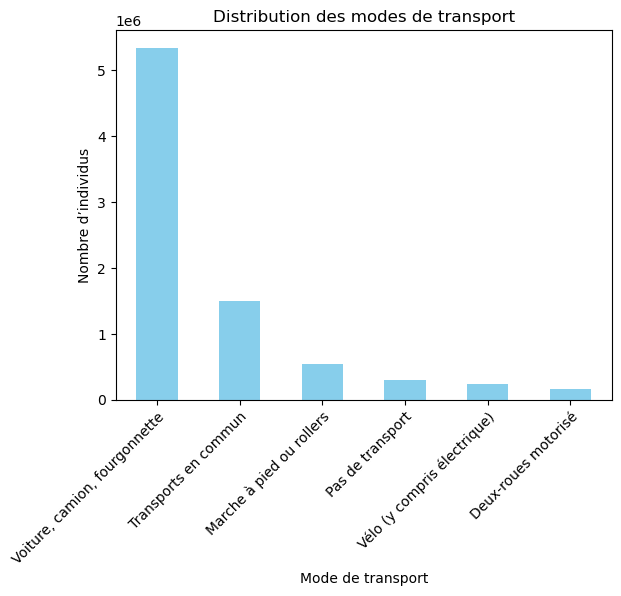

In [4]:
# Distribution des modes de transport utilisés pour aller travailler
transport_distribution = df_mobpro_brut['TRANS_LABEL'].value_counts()
print(transport_distribution)

# Visualisation
transport_distribution.plot(kind='bar', color='skyblue')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Distribution des modes de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Nombre d’individus')
plt.show()

TRANS_LABEL
Deux-roues motorisé              38.061997
Marche à pied ou rollers         38.992081
Pas de transport                 44.077751
Transports en commun             37.170818
Voiture, camion, fourgonnette    39.720284
Vélo (y compris électrique)      38.212106
Name: AGEREVQ, dtype: float64


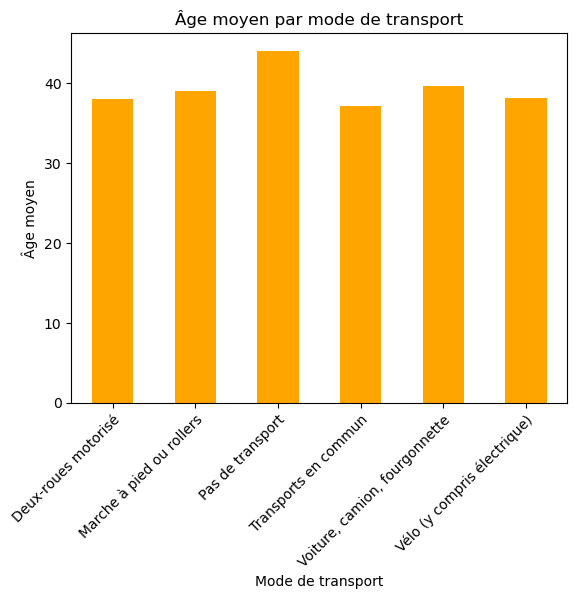

In [5]:
# Âge moyen par mode de transport
age_transport = df_mobpro_brut.groupby('TRANS_LABEL')['AGEREVQ'].mean()
print(age_transport)

# Visualisation
age_transport.plot(kind='bar', color='orange')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.title('Âge moyen par mode de transport')
plt.xlabel('Mode de transport')
plt.ylabel('Âge moyen')
plt.show()


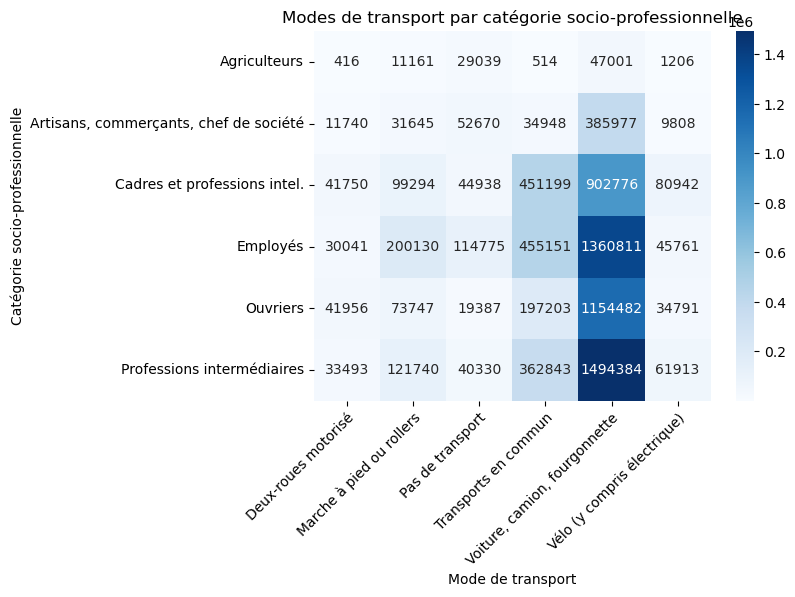

In [6]:
# Distribution des modes de transport par catégorie socio-professionnelle avec labels
cs1_transport = pd.crosstab(df_mobpro_brut['CS_LABEL'], df_mobpro_brut['TRANS_LABEL'])

# Heatmap
sns.heatmap(cs1_transport, annot=True, fmt='d', cmap='Blues')
plt.title('Modes de transport par catégorie socio-professionnelle')
plt.xlabel('Mode de transport')

# Inclinaison des labels avec alignement pour que l'extrémité pointe vers l'axe
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('Catégorie socio-professionnelle')
plt.show()


La fonction ci-dessous permet d'obtenir un premier tableau regroupant certaines informations par commune :
- Nombre de personnes du ménage (regroupé)
- Nombre de personnes scolarisées du ménage
- Nombre de personnes actives ayant un emploi du ménage
- Nombre d'élèves, étudiants ou stagiaires âgés de 14 ans ou plus du ménage
- Indicateur du lieu de travail
(1 Dans la commune de résidence actuelle
2 Dans une autre commune du département de résidence
3 Dans un autre département de la région de résidence
4 Hors de la région de résidence actuelle : en métropole
5 Hors de la région de résidence actuelle : dans un DOM
6 Hors de la région de résidence actuelle : dans une COM
7 A l'étranger)

In [7]:
# Conversion des colonnes en numérique
df_mobpro_brut['NPERR'] = pd.to_numeric(df_mobpro_brut['NPERR'], errors='coerce')
df_mobpro_brut['INPSM'] = pd.to_numeric(df_mobpro_brut['INPSM'], errors='coerce')
df_mobpro_brut['INPOM'] = pd.to_numeric(df_mobpro_brut['INPOM'], errors='coerce')
df_mobpro_brut['INEEM'] = pd.to_numeric(df_mobpro_brut['INEEM'], errors='coerce')

# Création des agrégations de base
mobpro_villes = df_mobpro_brut.groupby('COMMUNE').agg({
    'NPERR': 'sum',
    'INPSM': 'sum',
    'INPOM': 'sum',
    'INEEM': 'sum'})

# Créons d'abord un DataFrame temporaire pour chaque valeur d'ILT
for i in range(1, 8):
    # Grouper par COMMUNE et compter les occurrences où ILT == str(i)
    temp_count = df_mobpro_brut[df_mobpro_brut['ILT'] == i].groupby('COMMUNE').size()
    # Ajouter cette série au DataFrame principal
    mobpro_villes[f'ILT_{i}'] = temp_count

# Remplir les valeurs manquantes (NaN) par 0
mobpro_villes = mobpro_villes.fillna(0)

# Réinitialisation de l'index
mobpro_villes = mobpro_villes.reset_index()

In [8]:
mobpro_villes.head()

,COMMUNE,NPERR,INPSM,INPOM,INEEM,ILT_1,ILT_2,ILT_3,ILT_4,ILT_5,ILT_6,ILT_7
0,01001,275.0,65.0,194.0,13.0,11.0,58.0,20.0,1.0,0.0,0.0,0.0
1,01002,70.0,28.0,41.0,2.0,4.0,15.0,3.0,1.0,0.0,0.0,0.0
2,01004,6481.0,1787.0,3854.0,469.0,894.0,1105.0,422.0,33.0,0.0,0.0,5.0
3,01005,522.0,148.0,335.0,40.0,31.0,49.0,96.0,1.0,0.0,0.0,0.0
4,01006,35.0,4.0,31.0,0.0,1.0,7.0,5.0,0.0,0.0,0.0,0.0


On souhaite créer une matrice des flux pour avoir une vision générale des trajets domicile-travail quotidiens entre les villes. Pour chaque couple de ville, le nombre correspondant dans la matrice correspond au nombre de commute effectué de la ville 1 à la ville 2. 

On remarque que pour la variable "COMMUNE" (commune de résidence) on a uniquement 75056 pour Paris (idem pour Lyon et Marseille), tandis que pour la variable "DCLT" (commune de travail) on a un découpage en arrondissement avec les codes 75101,... pour Paris (idem pour Lyon et Marseille). Afin de pallier cette différence, on se cale sur l'échelle des arrondissements en remplaçant la valeur de "COMMUNE" par celle de "ARM" lorsque la ville en question est Paris, Marseille ou Lyon.

In [9]:
# Création d'une table croisée dynamique pour compter les déplacements
# Il faut que la matrice soit carrée pour qu'on ait bien tous les couples possibles de communes
flux_tot = pd.crosstab(df_mobpro_brut['COMMUNE'], df_mobpro_brut['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_mobpro_brut['COMMUNE']).union(df_mobpro_brut['DCLT'])))
flux_tot_carre = flux_tot.reindex(index=all_values, columns=all_values, fill_value=0)
flux_tot=flux_tot_carre

# Conversion en DataFrame pour plus de clarté
flux_tot = pd.DataFrame(flux_tot)

# Pour voir les dimensions de la matrice
print("Dimensions de la matrice :", flux_tot.shape)

Dimensions de la matrice : (34946, 34946)


In [10]:
# Filtrer les données pour chaque groupe de transport
df_trans_45 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([4, 5])]
df_trans_6 = df_mobpro_brut[df_mobpro_brut['TRANS'] == 6]
df_trans_123 = df_mobpro_brut[df_mobpro_brut['TRANS'].isin([1, 2, 3])]

In [ ]:
import pandas as pd

communes_unique = df_trans_45['COMMUNE'].nunique()
dclt_unique = df_trans_45['DCLT'].nunique()
flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'], dropna=False)
print(f"Dimensions avant réindexation : {flux_rouge.shape}")
all_values = pd.Index(sorted(set(df_trans_45['COMMUNE']).union(df_trans_45['DCLT'])))
flux_rouge_carre = flux_rouge.reindex(index=all_values, columns=all_values, fill_value=0)
print(f"Dimensions après réindexation : {flux_rouge_carre.shape}")
flux_rouge = flux_rouge_carre


Nombre de valeurs uniques dans COMMUNE : 34817
Nombre de valeurs uniques dans DCLT : 33012
Premières valeurs uniques de COMMUNE: ['01001' '01002' '01004' '01005' '01006' '01007' '01008' '01009' '01010'
 '01011']
Premières valeurs uniques de DCLT: ['01001' '01004' '01053' '01088' '01093' '01134' '01166' '01235' '01244'
 '01261']
Dimensions avant réindexation : (34817, 33012)
Dimensions après réindexation : (34903, 34903)


In [12]:
# Créer les matrices des flux rouges

flux_rouge = pd.crosstab(df_trans_45['COMMUNE'], df_trans_45['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_trans_45['COMMUNE']).union(df_trans_45['DCLT'])))
flux_rouge_carre = flux_rouge.reindex(index=all_values, columns=all_values, fill_value=0)
flux_rouge=flux_rouge_carre
print(flux_rouge.shape)

(34903, 34903)


In [13]:
# Créer les matrices des flux jaunes

flux_jaune = pd.crosstab(df_trans_6['COMMUNE'], df_trans_6['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_trans_6['COMMUNE']).union(df_trans_6['DCLT'])))
flux_jaune_carre = flux_jaune.reindex(index=all_values, columns=all_values, fill_value=0)
flux_jaune=flux_jaune_carre
print(flux_jaune.shape)

(18985, 18985)


In [14]:
# Créer les matrices des flux verts

flux_vert = pd.crosstab(df_trans_123['COMMUNE'], df_trans_123['DCLT'], dropna=False)
all_values = pd.Index(sorted(set(df_trans_123['COMMUNE']).union(df_trans_123['DCLT'])))
flux_vert_carre = flux_vert.reindex(index=all_values, columns=all_values, fill_value=0)
flux_vert=flux_vert_carre
print(flux_vert.shape)

(30456, 30456)


In [15]:
# Convertir en DataFrame pour plus de clarté
flux_rouge = pd.DataFrame(flux_rouge)
flux_jaune = pd.DataFrame(flux_jaune)
flux_vert = pd.DataFrame(flux_vert)

# Afficher les dimensions des matrices
print("Dimensions de la matrice (TRANS = 4 ou 5) :", flux_rouge.shape)
print("Dimensions de la matrice (TRANS = 6) :", flux_jaune.shape)
print("Dimensions de la matrice (TRANS = 1, 2 ou 3) :", flux_vert.shape)


Dimensions de la matrice (TRANS = 4 ou 5) : (34903, 34903)
Dimensions de la matrice (TRANS = 6) : (18985, 18985)
Dimensions de la matrice (TRANS = 1, 2 ou 3) : (30456, 30456)


In [16]:
flux('78220', '75108', flux_jaune)

Nombre de personnes se déplaçant de 78220 vers 75108 : 2


In [17]:
flux_rouge

,01001,01002,01004,01005,01006,01007,01008,01009,01010,01011,...,98735,98736,98738,98753,98758,98807,98811,98815,98818,99999
01001,7,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01002,0,3,2,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01004,0,0,585,0,0,6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
01005,0,0,0,19,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01006,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98811,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98815,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98818,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Pour les départs : somme sur l'axe des colonnes (chaque ligne = ville de départ)
df_flux_jaune_depart = flux_jaune.sum(axis=1).reset_index()
df_flux_jaune_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_jaune_destination = flux_jaune.sum(axis=0).reset_index()
df_flux_jaune_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_jaune_depart.head())
print("Destination :", df_flux_jaune_destination.head())

df_flux_vert_depart = flux_vert.sum(axis=1).reset_index()
df_flux_vert_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_vert_destination = flux_vert.sum(axis=0).reset_index()
df_flux_vert_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_vert_depart.head())
print("Destination :", df_flux_vert_destination.head())

df_flux_rouge_depart = flux_rouge.sum(axis=1).reset_index()
df_flux_rouge_depart.columns = ['COMMUNE', 'flux_depart']

# Pour les arrivées : somme sur l'axe des lignes (chaque colonne = ville d'arrivée)
df_flux_rouge_destination = flux_rouge.sum(axis=0).reset_index()
df_flux_rouge_destination.columns = ['DCLT', 'flux_destination']

print("Départ :", df_flux_rouge_depart.head())
print("Destination :", df_flux_rouge_destination.head())


Départ :   COMMUNE  flux_depart
0   01001            1
1   01002            1
2   01004          342
3   01005            4
4   01007           21
Destination :     DCLT  flux_destination
0  01001                 0
1  01002                 0
2  01004               116
3  01005                 2
4  01007                 2
Départ :   COMMUNE  flux_depart
0   01001            4
1   01002            1
2   01004          297
3   01005           14
4   01007           10
Destination :     DCLT  flux_destination
0  01001                 4
1  01002                 1
2  01004               304
3  01005                12
4  01007                12
Départ :   COMMUNE  flux_depart
0   01001           85
1   01002           21
2   01004         1820
3   01005          159
4   01006           13
Destination :     DCLT  flux_destination
0  01001                11
1  01002                 4
2  01004              1644
3  01005                53
4  01006                 1


In [19]:
df_flux_jaune_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_jaune_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_jaune_depart_m["flux_depart"] = df_flux_jaune_depart_m["flux_depart"].fillna(0).astype(int)

df_flux_vert_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_vert_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_vert_depart_m["flux_depart"] = df_flux_vert_depart_m["flux_depart"].fillna(0).astype(int)

df_flux_rouge_depart_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_rouge_depart,
        left_on='INSEE_COM',
        right_on="COMMUNE",
        how='left')
df_flux_rouge_depart_m["flux_depart"] = df_flux_rouge_depart_m["flux_depart"].fillna(0).astype(int)


df_flux_jaune_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_jaune_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_jaune_destination_m["flux_destination"] = df_flux_jaune_destination_m["flux_destination"].fillna(0).astype(int)

df_flux_vert_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_vert_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_vert_destination_m["flux_destination"] = df_flux_vert_destination_m["flux_destination"].fillna(0).astype(int)

df_flux_rouge_destination_m = pd.merge(
        contours_comm[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry']],
        df_flux_rouge_destination,
        left_on='INSEE_COM',
        right_on="DCLT",
        how='left')
df_flux_rouge_destination_m["flux_destination"] = df_flux_rouge_destination_m["flux_destination"].fillna(0).astype(int)

In [20]:
""" OBTENTION DE final_df RECENSANT POUR CHAQUE VILLE TOUS LES TYPES DE FLUX ET INFOS SOCIO"""
""" OBTENTION DE df_epci_contours INDIQUANT POUR CHAQUE EPCI QUELQUES CARACTERISTIQUES ET SES CONTOURS"""

# Merge des données socio et contours communes
df_socio = pd.merge(
    contours_comm,
    df_dossier_complet_brut[['CODGEO', 'P21_SAL15P', 'C21_MEN', 'P21_ACTOCC15P_TP']],
    left_on='INSEE_COM',
    right_on='CODGEO',
    how='left')
    
# Fusionner tous les flux dans un unique DataFrame
final_df = df_socio[['INSEE_COM', 'NOM', 'POPULATION', 'INSEE_DEP', 'SIREN_EPCI', 'geometry', 'P21_SAL15P', 'C21_MEN', 'P21_ACTOCC15P_TP']].copy()

# Ajouter les colonnes de flux en les fusionnant avec le DataFrame principal
for color in ['jaune', 'vert', 'rouge']:
    df_depart = globals()[f'df_flux_{color}_depart']
    df_destination = globals()[f'df_flux_{color}_destination']
    
    df_depart_m = pd.merge(final_df, df_depart, left_on='INSEE_COM', right_on='COMMUNE', how='left')
    df_destination_m = pd.merge(final_df, df_destination, left_on='INSEE_COM', right_on='DCLT', how='left')
    
    final_df[f'flux_depart_{color}'] = df_depart_m['flux_depart'].fillna(0).astype(int)
    final_df[f'flux_destination_{color}'] = df_destination_m['flux_destination'].fillna(0).astype(int)

# Renommer les colonnes
final_df = final_df.rename(columns={
    'P21_SAL15P': 'Nb actifs occupés en 2021',
    'C21_MEN': 'Nb ménages en 2021',
    'P21_ACTOCC15P_TP': 'Nb actifs à temps partiel'})

# Conversion en GeoDataFrame si nécessaire
if not isinstance(final_df, gpd.GeoDataFrame):
    final_df = gpd.GeoDataFrame(final_df, geometry='geometry')

# Partie données
df_epci_data = final_df.groupby('SIREN_EPCI').agg({
    'NOM': list,
    'INSEE_COM': list,
    'INSEE_DEP': list,
    'POPULATION': 'sum',
    'Nb actifs à temps partiel': 'sum',
    'Nb ménages en 2021':'sum',
    'Nb actifs occupés en 2021':'sum'
}).reset_index()

# Partie géométrie
df_epci_geo = final_df.dissolve(by='SIREN_EPCI')

# Merge des deux
df_epci_contours = df_epci_data.merge(df_epci_geo[['geometry']], left_on='SIREN_EPCI', right_index=True)


In [21]:
df_epci_contours.head()

,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry
0,200000172,"[Marignier, Contamine-sur-Arve, Glières-Val-de...","[74164, 74087, 74212, 74312, 74049, 74042, 74024]","[74, 74, 74, 74, 74, 74, 74]",27218.0,2218.427898,11802.018216,12031.433753,"POLYGON ((6.45511 46.05427, 6.45502 46.05414, ..."
1,200000438,"[Crossac, Pontchâteau, Sainte-Anne-sur-Brivet,...","[44050, 44129, 44152, 44098, 44068, 44196, 441...","[44, 44, 44, 44, 44, 44, 44, 44, 44]",35917.0,2756.235128,15784.280047,14384.550345,"POLYGON ((-1.98129 47.47193, -1.98101 47.47168..."
2,200000545,"[Crancey, Saint-Hilaire-sous-Romilly, Romilly-...","[10114, 10341, 10323, 10164, 10220, 10280]","[10, 10, 10, 10, 10, 10]",18739.0,874.965660,8665.218943,5446.249610,"POLYGON ((3.7003 48.471, 3.69984 48.47079, 3.6..."
3,200000628,"[Lapalud, Mondragon, Mornas, Lamotte-du-Rhône,...","[84064, 84078, 84083, 84063, 84019]","[84, 84, 84, 84, 84]",24224.0,1442.982297,10773.779439,7526.326339,"POLYGON ((4.77447 44.21073, 4.77183 44.21077, ..."
4,200000800,"[Chaumont-sur-Tharonne, Chaon, Vouzon, Nouan-l...","[41046, 41036, 41296, 41161, 41106, 41251]","[41, 41, 41, 41, 41, 41]",10437.0,550.174086,4746.154398,3763.453777,"POLYGON ((2.08755 47.58796, 2.08697 47.58708, ..."


In [22]:
#plot_flux_gradient(df_flux_rouge_depart_m, "rouge", "Figure - Flux (domicile-travail) de départ \n en voiture/moto par commune","flux_depart")

In [23]:
#plot_flux_gradient(df_flux_jaune_depart_m, "jaune", "Figure - Flux (domicile-travail) de départ \n en transport en commun par commune","flux_depart")

In [24]:
#plot_flux_gradient(df_flux_vert_depart_m, "vert", "Figure - Flux (domicile-travail) de départ \n à pied","flux_depart")

In [25]:
#plot_flux_gradient(df_flux_rouge_destination_m, "rouge", "Figure - Flux (domicile-travail) d'arrivée \n en voiture/moto","flux_destination")

In [26]:
#plot_flux_gradient(df_flux_jaune_destination_m, "jaune", "Figure - Flux (domicile-travail) d'arrivée \n en transport en commun","flux_destination")

In [27]:
#plot_flux_gradient(df_flux_vert_destination_m, "vert", "Figure - Flux (domicile-travail) d'arrivée \n à pied","flux_destination")

In [28]:
#plot_flux_gradient_zoom(df_flux_jaune_destination_m, "jaune", "Figure - Flux (domicile-travail) d'arrivée \n en transports en commun","flux_destination", "grenoble")

In [29]:
def est_mono_departement(liste_departements):
    '''
    On vérifie si les EPCI regroupent forcément des villes qui appartiennent au même département (réponse = non pas systématiquement)
    '''
    return len(set(liste_departements)) == 1
    
    
# Appliquer la fonction à chaque ligne et créer une nouvelle colonne
df_epci_contours['MONO_DEP'] = df_epci_contours['INSEE_DEP'].apply(est_mono_departement)

In [30]:
"""OBTENTION DE gdf_epci_metropole IGNORANT LES EPCI HORS FRANCE METROPOLITAINE"""

def est_metropole(liste_departements):
    """
    On ne souhaite afficher que la France Métropolitaine et exclure les DOM-TOM et la Corse.
    """
    # Filtrage : ignorer les départements dont le code dépasse 3 caractères
    liste_departements = [dep for dep in liste_departements if len(str(dep)) <= 3]

    for dep in liste_departements:
        # On vérifie si le code contient des lettres, comme '2A' ou '2B'
        if any(c.isalpha() for c in dep):
            return False  # Exclure la Corse ou d'autres DOM-TOM avec des lettres

        # Comparer avec 970 pour la métropole
        if int(dep) >= 970:
            return False  # Exclure les départements DOM-TOM
    
    return True  # Si toutes les conditions sont remplies, c'est en métropole
    
gdf_epci_metropole = df_epci_contours[df_epci_contours['INSEE_DEP'].apply(est_metropole)]


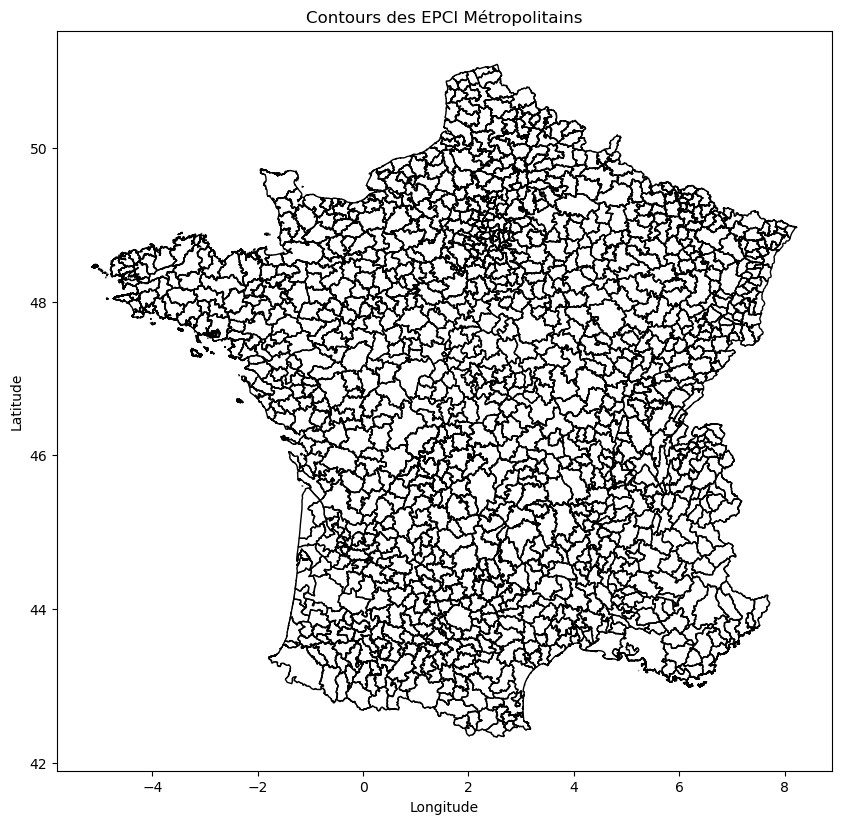

In [31]:
""" AFFICHAGE CARTE EPCI"""

gdf_epci_metropole = gpd.GeoDataFrame(gdf_epci_metropole, geometry='geometry')

# Tracer les géométries
fig, ax = plt.subplots(figsize=(10, 10))  # Taille de la figure
gdf_epci_metropole.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
plt.title("Contours des EPCI Métropolitains")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [32]:
""" OBTENTION DE df_epci_flux QUI RECENSE LES NOMBRES DE FLUX PAR EPCI"""

# Merge pour récupérer EPCI de départ
df_mobpro_brut = df_mobpro_brut.merge(
    contours_comm[['INSEE_COM', 'SIREN_EPCI']],
    left_on='COMMUNE',
    right_on='INSEE_COM',
    how='left'
).rename(columns={'SIREN_EPCI': 'EPCI_DEP'}).drop('INSEE_COM', axis=1)

# Merge pour récupérer EPCI d'arrivée
df_mobpro_brut = df_mobpro_brut.merge(
    contours_comm[['INSEE_COM', 'SIREN_EPCI']],
    left_on='DCLT',
    right_on='INSEE_COM',
    how='left'
).rename(columns={'SIREN_EPCI': 'EPCI_ARR'}).drop('INSEE_COM', axis=1)

df_mobpro_brut['is_intra'] = df_mobpro_brut['EPCI_DEP'] == df_mobpro_brut['EPCI_ARR']

# Calcul des flux intra
flux_intra = df_mobpro_brut[df_mobpro_brut['is_intra']].groupby('EPCI_DEP').size().reset_index(name='flux_intra_epci')

# Calcul des flux sortants
flux_sortant = df_mobpro_brut[~df_mobpro_brut['is_intra']].groupby('EPCI_DEP').size().reset_index(name='flux_sortant')

# Calcul des flux entrants
flux_entrant = df_mobpro_brut[~df_mobpro_brut['is_intra']].groupby('EPCI_ARR').size().reset_index(name='flux_entrant')

# Calcul des flux par type de transport (TRANS = 6 : TC, TRANS = 1,2,3 : Zero, TRANS = 4,5 : VC2RM)
flux_sortant_TC = df_mobpro_brut[(df_mobpro_brut['TRANS'] == 6) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_DEP').size().reset_index(name='flux_sortant_TC')
flux_entrant_TC = df_mobpro_brut[(df_mobpro_brut['TRANS'] == 6) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_ARR').size().reset_index(name='flux_entrant_TC')
flux_sortant_VC2RM = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([4, 5])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_DEP').size().reset_index(name='flux_sortant_VC2RM')
flux_entrant_VC2RM = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([4, 5])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_ARR').size().reset_index(name='flux_entrant_VC2RM')
flux_sortant_Zero = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([1, 2, 3])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_DEP').size().reset_index(name='flux_sortant_Zero')
flux_entrant_Zero = df_mobpro_brut[(df_mobpro_brut['TRANS'].isin([1, 2, 3])) & (~df_mobpro_brut['is_intra'])].groupby('EPCI_ARR').size().reset_index(name='flux_entrant_Zero')

# Création du DataFrame final avec SIREN_EPCI comme clé unique
# Commencer par créer un DataFrame avec tous les EPCI uniques
all_epci = pd.concat([
    flux_intra[['EPCI_DEP']],
    flux_sortant[['EPCI_DEP']],
    flux_entrant[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'}),
    flux_sortant_TC[['EPCI_DEP']],
    flux_entrant_TC[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'}),
    flux_sortant_VC2RM[['EPCI_DEP']],
    flux_entrant_VC2RM[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'}),
    flux_sortant_Zero[['EPCI_DEP']],
    flux_entrant_Zero[['EPCI_ARR']].rename(columns={'EPCI_ARR': 'EPCI_DEP'})
]).drop_duplicates().rename(columns={'EPCI_DEP': 'SIREN_EPCI'})

# Fusion des flux dans un seul DataFrame
df_epci_flux = all_epci.copy()

# Fusionner tous les flux en utilisant des suffixes explicites et en maintenant SIREN_EPCI comme clé
df_epci_flux = pd.merge(df_epci_flux, flux_intra.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant_TC.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant_TC.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant_VC2RM.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant_VC2RM.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_sortant_Zero.rename(columns={'EPCI_DEP': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

df_epci_flux = pd.merge(df_epci_flux, flux_entrant_Zero.rename(columns={'EPCI_ARR': 'SIREN_EPCI'}), 
                        on='SIREN_EPCI', how='left')

# Remplacer les NA par des 0
df_epci_flux = df_epci_flux.fillna(0)

# Convertir en int
for col in ['flux_intra_epci', 'flux_sortant', 'flux_entrant', 'flux_sortant_TC', 'flux_entrant_TC', 
            'flux_sortant_VC2RM', 'flux_entrant_VC2RM', 'flux_sortant_Zero', 'flux_entrant_Zero']:
    df_epci_flux[col] = df_epci_flux[col].astype(int)

# Résultat final
df_epci_flux.head()

,SIREN_EPCI,flux_intra_epci,flux_sortant,flux_entrant,flux_sortant_TC,flux_entrant_TC,flux_sortant_VC2RM,flux_entrant_VC2RM,flux_sortant_Zero,flux_entrant_Zero
0,200000172,1431,2391,2239,71,71,2271,2132,49,36
1,200000438,1233,2451,880,105,17,2330,854,16,9
2,200000545,1070,1001,770,199,35,784,723,18,12
3,200000628,1137,1386,1027,47,29,1326,993,13,5
4,200000800,432,408,410,33,41,367,364,8,5


In [33]:
gdf_epci = gdf_epci_metropole.merge(df_epci_flux[['SIREN_EPCI', 'flux_intra_epci', 'flux_sortant', 'flux_entrant','flux_sortant_TC','flux_entrant_TC','flux_sortant_VC2RM','flux_entrant_VC2RM','flux_sortant_Zero','flux_entrant_Zero']], on='SIREN_EPCI', how='left')

In [34]:
gdf_epci.sample()

,SIREN_EPCI,NOM,INSEE_COM,INSEE_DEP,POPULATION,Nb actifs à temps partiel,Nb ménages en 2021,Nb actifs occupés en 2021,geometry,MONO_DEP,flux_intra_epci,flux_sortant,flux_entrant,flux_sortant_TC,flux_entrant_TC,flux_sortant_VC2RM,flux_entrant_VC2RM,flux_sortant_Zero,flux_entrant_Zero
693,200073237,"[Épeigné-sur-Dême, Cerelles, Villebourg, Beaum...","[37101, 37047, 37274, 37021, 37059, 37167, 372...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...",21980.0,1397.687764,9035.007889,8927.619903,"POLYGON ((0.58366 47.44683, 0.58385 47.44649, ...",True,522,1572,449,29,10,1533,432,10,7


In [35]:
'''gdf_epci_metropole['ind_TC'] = (
    gdf_epci_metropole['flux_destination_jaune']/
    gdf_epci_metropole['Nb actifs occupés en 2021'])'''


# Calcul du ratio (éviter la division par zéro)
gdf_epci['ratio'] = gdf_epci['flux_sortant'] / gdf_epci['flux_entrant'].replace(0, 1)

# Nettoyage de la colonne INSEE_DEP en supprimant les doublons dans les listes
gdf_epci['INSEE_DEP'] = gdf_epci['INSEE_DEP'].apply(lambda x: list(set(x)) if isinstance(x, list) else x)

In [36]:
'''
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Exemple de données : chaque ligne est une ville, chaque colonne une variable ---
data = gdf_epci_metropole

# --- Sélection des variables à utiliser ---
selected_vars = ['ratio', 'Nb actifs occupés en 2021', 'ind_TC']  # On choisit les variables pertinentes
X = data[selected_vars].copy()  # On extrait les données

# --- Pondération des variables (facultatif) ---
weights = np.array([0.4, 0.3, 0.3])  # Importance de chaque variable
X_weighted = X * weights  # Multiplication élément par élément

# --- Normalisation des données ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_weighted)  # Mise à l'échelle pour équilibrer les unités

# --- Application du K-Means ---
k = 10  # Nombre de clusters (à adapter selon l'analyse)
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(X_scaled)  # Ajout des clusters au DataFrame

# --- Affichage des résultats ---
print(data[['SIREN_EPCI', 'cluster']])
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn.preprocessing import StandardScaler\n\n# --- Exemple de données : chaque ligne est une ville, chaque colonne une variable ---\ndata = gdf_epci_metropole\n\n# --- Sélection des variables à utiliser ---\nselected_vars = ['ratio', 'Nb actifs occupés en 2021', 'ind_TC']  # On choisit les variables pertinentes\nX = data[selected_vars].copy()  # On extrait les données\n\n# --- Pondération des variables (facultatif) ---\nweights = np.array([0.4, 0.3, 0.3])  # Importance de chaque variable\nX_weighted = X * weights  # Multiplication élément par élément\n\n# --- Normalisation des données ---\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X_weighted)  # Mise à l'échelle pour équilibrer les unités\n\n# --- Application du K-Means ---\nk = 10  # Nombre de clusters (à adapter selon l'analyse)\nkmeans = KMeans(n_clusters=k, random_state=42, n_init=10)\ndata['cluster'] = kmeans.fit_predict(X_scaled)  # Ajout des clusters au DataFrame\n\n

In [37]:
'''
import matplotlib.colors as mcolors


# Définir une palette de couleurs adaptée au nombre de clusters
num_clusters = data['cluster'].nunique()
colors = plt.cm.get_cmap('tab20', num_clusters)  # 'tab20', 'viridis', etc.

# Associer une couleur à chaque cluster
data['color'] = data['cluster'].apply(lambda x: colors(x))

# Tracer la carte
fig, ax = plt.subplots(figsize=(10, 10))
data.plot(column='cluster', cmap=colors, legend=True, edgecolor="black", ax=ax)

# Personnalisation
ax.set_title("Clustering des EPCI", fontsize=15)
ax.axis("off")  # Supprimer les axes

# Afficher la carte
plt.show()
'''

'\nimport matplotlib.colors as mcolors\n\n\n# Définir une palette de couleurs adaptée au nombre de clusters\nnum_clusters = data[\'cluster\'].nunique()\ncolors = plt.cm.get_cmap(\'tab20\', num_clusters)  # \'tab20\', \'viridis\', etc.\n\n# Associer une couleur à chaque cluster\ndata[\'color\'] = data[\'cluster\'].apply(lambda x: colors(x))\n\n# Tracer la carte\nfig, ax = plt.subplots(figsize=(10, 10))\ndata.plot(column=\'cluster\', cmap=colors, legend=True, edgecolor="black", ax=ax)\n\n# Personnalisation\nax.set_title("Clustering des EPCI", fontsize=15)\nax.axis("off")  # Supprimer les axes\n\n# Afficher la carte\nplt.show()\n'

In [38]:
'''
selected_vars = ['ratio', 'Nb actifs occupés en 2021', 'ind_TC']  
X = data[selected_vars].copy()

# --- Pondération des variables ---
weights = np.array([0.4, 0.3, 0.3])  # Importance de chaque variable
X_weighted = X * weights  # Multiplication élément par élément

# --- Normalisation des données ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Test de plusieurs valeurs de k ---
inerties = []
k_values = range(1, 20)  # Tester de 1 à 20 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inerties.append(kmeans.inertia_)  # Stocker l'inertie

# --- Tracer la courbe du coude ---
plt.figure(figsize=(8, 5))
plt.plot(k_values, inerties, marker='o', linestyle='-')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.title("Méthode du coude pour choisir k")
plt.xticks(k_values)
plt.grid()
plt.show()
'''

'\nselected_vars = [\'ratio\', \'Nb actifs occupés en 2021\', \'ind_TC\']  \nX = data[selected_vars].copy()\n\n# --- Pondération des variables ---\nweights = np.array([0.4, 0.3, 0.3])  # Importance de chaque variable\nX_weighted = X * weights  # Multiplication élément par élément\n\n# --- Normalisation des données ---\nscaler = StandardScaler()\nX_scaled = scaler.fit_transform(X)\n\n# --- Test de plusieurs valeurs de k ---\ninerties = []\nk_values = range(1, 20)  # Tester de 1 à 20 clusters\n\nfor k in k_values:\n    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)\n    kmeans.fit(X_scaled)\n    inerties.append(kmeans.inertia_)  # Stocker l\'inertie\n\n# --- Tracer la courbe du coude ---\nplt.figure(figsize=(8, 5))\nplt.plot(k_values, inerties, marker=\'o\', linestyle=\'-\')\nplt.xlabel("Nombre de clusters (k)")\nplt.ylabel("Inertie intra-cluster")\nplt.title("Méthode du coude pour choisir k")\nplt.xticks(k_values)\nplt.grid()\nplt.show()\n'